In [115]:
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal

# TP 4: Improve the Metropolis-Hastings algorithm

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler
### 1.A – Metropolis-Hastings within Gibbs sampler

In [2]:
def pi(z,a = 10):
    """Computes pi distribution with parameter a evaluated in x,y"""
    x2 = z[0]**2
    y2 = z[1]**2
    return np.exp(-x2/a**2 - y2 - 0.25*(x2/a**2 - y2)**2)

In [36]:
def sampler_coord(z, coord, sigma, n_iter=100):
    """ Sample from P1 or P2, depending on the value of coord paramter, iterates n_iter times"""
    a = 10
    if coord != 0 and coord != 1:
        print("ERROR COORDINATE")

    acceptance_rate = 0
    x,y = z[0], z[1]
    for i_ in range(n_iter):
        if coord == 0:
            x_new, y_new = np.random.normal(loc=x, scale=sigma), y
        else:
            x_new, y_new = x, np.random.normal(loc=y, scale=sigma)
        
        log_u = log(np.random.random())
        log_alpha = min(log(pi([x_new, y_new], a)) - log(pi([x, y], a)), 0)
        # Test acceptation
        if log_u < log_alpha:
            x,y = x_new, y_new
        acceptance_rate += np.exp(log_alpha)

    return np.array([x,y]), acceptance_rate/n_iter


In [19]:
def sample_p(start, sigmas = (3,3), n_iter = 1000, verbose = 0):
    """Samples n_iter samples from distribution P 

    Args:
        start : strating point ndarray of shape (2)
        sigmas (tuple, optional): Proposition standard deviations. Defaults to (3,3).
        n_iter (int, optional): number of samples. Defaults to 1000.
        verbose (int, optional): Defaults to 0.

    Returns:
        [type]: [description]
    """

    samples = [start]
    sigma1, sigma2= sigmas
    acc_history_x, acc_history_y = [], []
    
    for i in range(n_iter):
        if verbose and not i%1000:
            print(i)
        # samples P1 and P2
        sam_x, acc_x = sampler_coord(samples[i], 0, sigma1)
        sam_y, acc_y = sampler_coord(samples[i], 1, sigma2)

        # Append sample and intermediate acceptances
        samples.append(0.5*(sam_x + sam_y))
        acc_history_x.append(acc_x)
        acc_history_y.append(acc_y)

    return np.array(samples), (acc_history_x, acc_history_y) 

Run the sampler for 2500 iterations

In [21]:
samples, (acc_x, acc_y) = sample_p([2,1], n_iter= 2500, verbose = True)

0


/tmp/ipykernel_4130/2662019745.py:18: RuntimeWarning: divide by zero encountered in log
  log_alpha = min(log(pi([x_new, y_new], a)) - log(pi([x, y], a)), 0)


1000
2000


Let's plot the samples

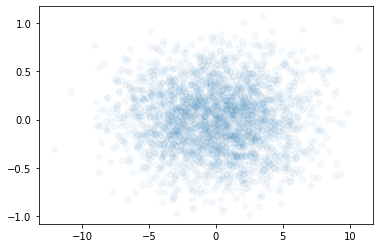

In [22]:
plt.scatter(samples[:,0], samples[:,1], alpha = 100/samples.shape[0])

Let's plot the acceptance rates obtained during execution

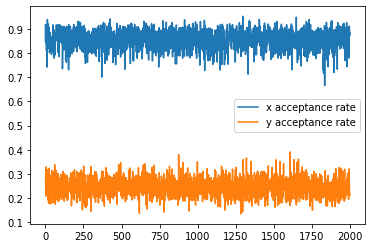

In [18]:
plt.plot(range(len(acc_x)), acc_x, label = "x acceptance rate")
plt.plot(range(len(acc_x)), acc_y, label = "y acceptance rate")
plt.legend()
plt.show()

We can notice that the acceptance rates are very different from one dimension to another. 

In [28]:
print("Mean acceptance in x:",np.mean(acc_x))
print("Mean acceptance in y:",np.mean(acc_y))

Mean acceptance in x: 0.8564067636030224
Mean acceptance in y: 0.24791161411512103


**Question 3.**

We can try to change the proposition sigma's in order to get more homogeneous results in both dimension

sigmas: (6.0, 2.0)


/tmp/ipykernel_4130/4130397951.py:16: RuntimeWarning: divide by zero encountered in log
  log_alpha = min(log(pi([x_new, y_new], a)) - log(pi([x, y], a)), 0)


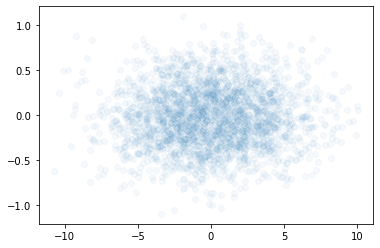

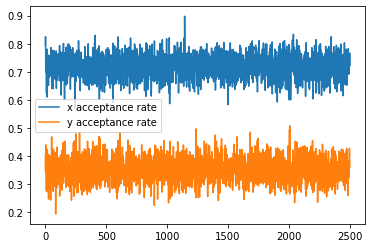

sigmas: (12.0, 1.0)


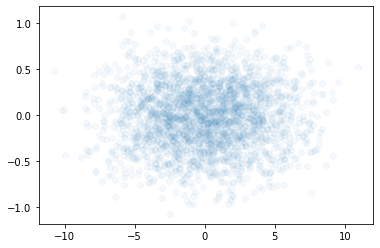

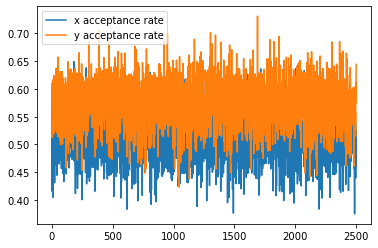

In [43]:
sigmas_list = [(6.,2.), (12.,1.)]

for sigmas in sigmas_list:
    print("sigmas:", sigmas)
    samples, (acc_x, acc_y) = sample_p([2,1], sigmas = sigmas, n_iter= 2500, verbose = 0)
    plt.scatter(samples[:,0], samples[:,1], alpha = 100/samples.shape[0])
    plt.show()
    plt.plot(range(len(acc_x)), acc_x, label = "x acceptance rate")
    plt.plot(range(len(acc_x)), acc_y, label = "y acceptance rate")
    plt.legend()
    plt.show()
    

We achieve more reasonable and homogeneous acceptance rates along both dimensions.

### 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

**Question 1.**

In [83]:
def adaptive_hm(start, n_iter = 1000, density = "pi_1", sigma_start = 1, adaptation = True, verbose = 0, return_hist = True):
    d = start.shape[0]
    z = start
    N_sub = 100
    l_prop = np.ones(d)*sigma_start

    samples = []
    history_accept = []
    history_sig_prop = [l_prop]

    for k in range(n_iter):
        accept = np.zeros(d)
        for kk_ in range(N_sub):
            for i in range(d):
                # Proposal
                z_prop = z.copy()
                z_prop[i] += np.random.normal(loc=0, scale= np.exp(l_prop[i]))

                if density == "pi_1":
                    log_alpha = log(pi(z_prop)) - log(pi(z))
                elif density == "banana":
                    log_alpha = log(pi_banana(z_prop)) - log(pi_banana(z))

                # Acceptation rate for component i update
                accept[i] += min(np.exp(log_alpha), 1)

                # Acceptation test
                if log(np.random.random()) < min(log_alpha, 0):
                    z = z_prop

        accept /= N_sub
        history_accept.append(accept)
        samples.append(z)

        # Adjust each log variance every 50 iterations
        if adaptation and not (k+1)%50:
            l_prop += min(0.01, k**-0.5)*((accept > 0.24)*2 -1)
            history_sig_prop.append(l_prop)
            if verbose == 2:
                print("update", k, accept, l_prop, k, min(0.01, (k+1)//50**-0.5)*((accept > 0.24)*2 -1))
    print()
    if return_hist:
        return np.array(samples), (np.array(history_accept), np.array(history_sig_prop)) 
    return np.array(samples) 

In [72]:
def result_description(samples,h_accept, h_sig_prop):
    # Plot samples
    plt.scatter(samples[:,0], samples[:,1], alpha = 150/samples.shape[0])
    plt.show()

    # x accetance rate evolution
    plt.scatter(range(h_accept.shape[0]), h_accept[:, 0], s= 1, alpha = 0.2)
    plt.title("Evolution of acceptance rate on x coordinate")
    plt.ylim(0, 1)
    plt.show()

    # y accetance rate evolution
    plt.title("Evolution of acceptance rate on y coordinate")
    plt.scatter(range(h_accept.shape[0]), h_accept[:, 1], s= 1, alpha = 0.2)
    plt.ylim(0, 1)
    # plt.plot(range(h_accept.shape[0]), h_accept[:, 1], alpha = 0.2)
    plt.show()

    # Autocorrelation
    pd.plotting.autocorrelation_plot(pd.Series(samples[:100,0]))
    # pd.plotting.autocorrelation_plot(pd.Series(samples[400:600,0]))

**With adaptation**

In [ ]:
samples, (h_accept, h_sig_prop) = adaptive_hm(np.zeros(2), density="pi_1", adaptation=True, verbose = 0, n_iter= 20000, return_hist=True)

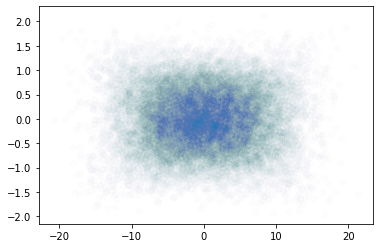

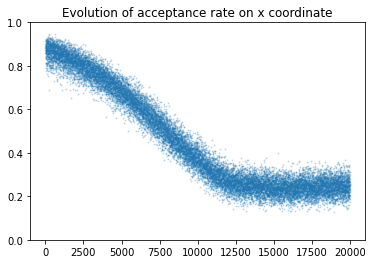

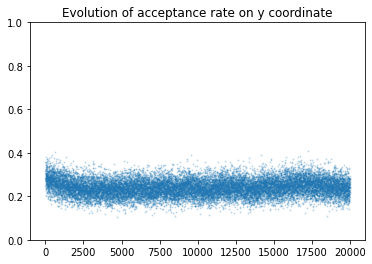

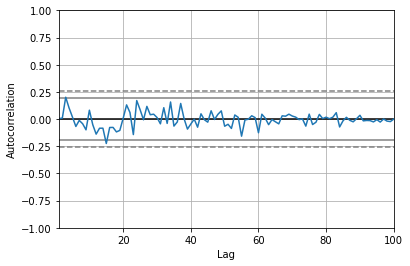

In [85]:
result_description(samples, h_accept, h_sig_prop)


**Without adaptation**

/tmp/ipykernel_4130/452702255.py:20: RuntimeWarning: divide by zero encountered in log
  log_alpha = log(pi(z_prop)) - log(pi(z))


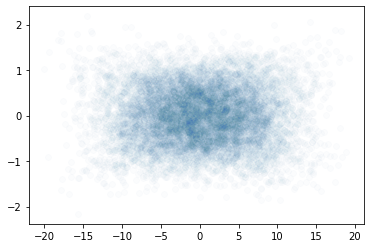

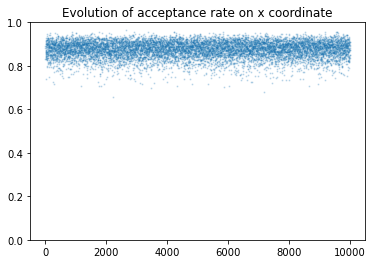

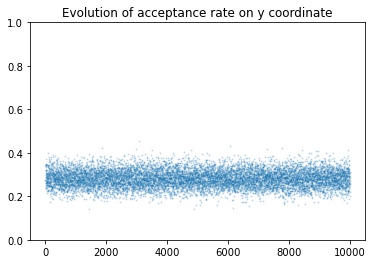

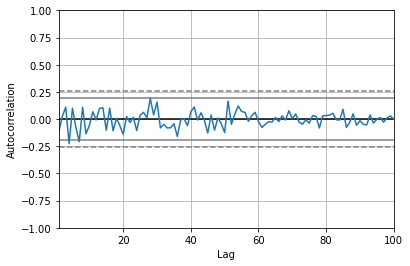

In [86]:
samples, (h_accept, h_sig_prop) = adaptive_hm(np.zeros(2), density="pi_1", adaptation=False, verbose = 0, n_iter= 10000, return_hist=True)
result_description(samples, h_accept, h_sig_prop)


**Question 2**

In [87]:
def pi_banana(z):
    B = 0.1
    return np.exp(-z[0]**2/200 - 0.5*(z[1]+B*z[0]**2- 100*B)**2 -0.5*np.sum(z[2:]**2))


/tmp/ipykernel_4130/452702255.py:22: RuntimeWarning: divide by zero encountered in log
  log_alpha = log(pi_banana(z_prop)) - log(pi_banana(z))


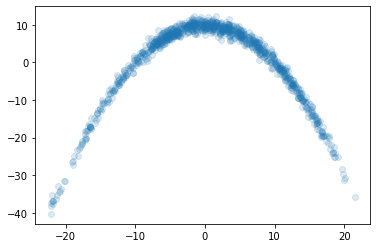

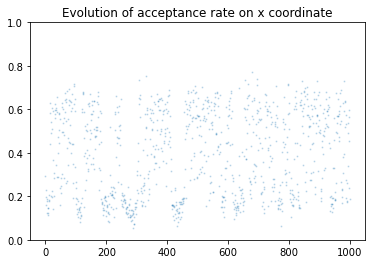

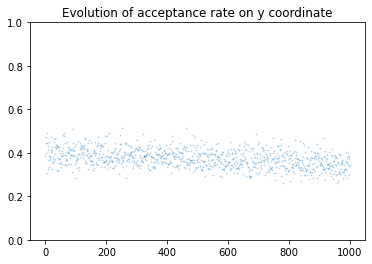

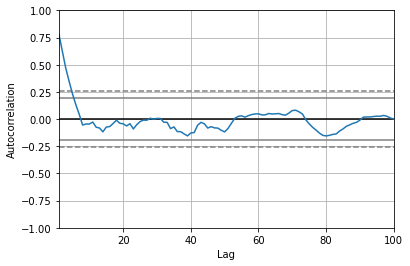

In [182]:
samples, (h_accept, h_sig_prop)  = adaptive_hm(np.zeros(20), n_iter = 1000, density = "banana", adaptation=True, verbose = 0)
result_description(samples, h_accept, h_sig_prop)


Test with an without adaptation

In [92]:
samples_1,_  = adaptive_hm(np.zeros(20), n_iter = 1000, density = "banana", sigma_start=3, adaptation = False)
samples_2,_ = adaptive_hm(np.zeros(20), n_iter = 1000, density = "banana", sigma_start=1, adaptation = False)
samples_3,_ = adaptive_hm(np.zeros(20), n_iter = 1000, density = "banana", sigma_start=0.1, adaptation = False)


/tmp/ipykernel_4130/452702255.py:22: RuntimeWarning: divide by zero encountered in log
  log_alpha = log(pi_banana(z_prop)) - log(pi_banana(z))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

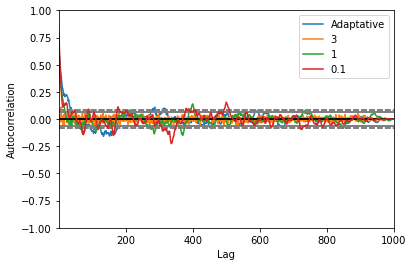

In [93]:
pd.plotting.autocorrelation_plot(pd.Series(samples[:,0]), label = "Adaptative")
pd.plotting.autocorrelation_plot(pd.Series(samples_1[:,0]), label = "3")
pd.plotting.autocorrelation_plot(pd.Series(samples_2[:,0]), label = "1")
pd.plotting.autocorrelation_plot(pd.Series(samples_3[:,0]), label = "0.1")


---
---
---

# Exercise 2: Sampling from multimodal distributions

In [486]:

mus = np.array([[2.18, 5.76],[8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], [3.25, 3.47], [1.7, 0.5], [4.59, 5.6], [6.91, 5.81], [6.87, 5.4], [
			5.41, 2.65], [2.7, 7.88], [4.98, 3.7], [1.14, 2.39], [8.33, 9.5], [4.93, 1.5], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])
def pi_mix(x):
    return 0.05*np.sum([multivariate_normal.pdf(x, mu, 0.1**2) for mu in mus])



## 2.A – A toy example

In [487]:
def hm_mixture(start, N=1000):
    z = start
    N_sub = 10
    sigma= 2.
    samples = []

    for k in range(N):
        # if not k%100:  
        #     print(k)
        # Proposal
        z_prop = z + np.random.normal(0, sigma, 2)
        log_alpha = log(pi_mix(z_prop)/pi_mix(z))
        # Acceptation test
        if log(np.random.random()) < min(log_alpha, 0):
            z = z_prop
        samples.append(z)
            
    return np.array(samples) 


In [469]:
samples_mixture_1 = hm_mixture(np.array([4,4]), 3000)

/tmp/ipykernel_8017/2540451112.py:12: RuntimeWarning: divide by zero encountered in log
  log_alpha = log(pi_mixture(z_prop)/pi_mixture(z))


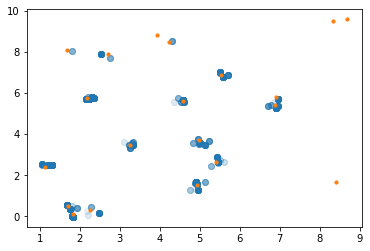

In [470]:
plt.scatter(samples_mixture_1[:,0], samples_mixture_1[:,1], alpha = 0.05)
plt.scatter(mus[:,0], mus[:,1], s =10)

We can see that we failed to samples from several gaussian within the mixture, as we do not get clusters for all means.

## 2.B – Parallel Tempering

In [599]:
def parallel_temp(start, T, N):
    """Samples using parallel tempering, with temperatures list T, for N iterations"""
    K = T.shape[0]
    Z = np.tile(start, (K, 1))
    cov_prop = np.array([(0.25**2)*T[k] * np.eye(2) for k in range(K)])
    samples_K = []
    for l in range(N):
        if not l % 1000:
            print(str(l)+"/"+str(N))

        ### HM ###
        Z = Z.copy()
        Z_prop = np.array([np.random.multivariate_normal(
            Z[k], cov_prop[k]) for k in range(K)])
        # HM acceptance test
        for k in range(K):
            log_alpha_hm = log(pi_mix(Z_prop[k]))/T[k] - log(pi_mix(Z[k]))/T[k]
            if log(np.random.random()) < min(log_alpha_hm, 0):
                Z[k, :] = Z_prop[k, :]

        ### Swap ###
        i = np.random.randint(0, K-1)
        log_pi_i = log(pi_mix(Z[i]))
        log_pi_j = log(pi_mix(Z[i+1]))
        log_alpha_swap = log_pi_i/T[i+1] + log_pi_j / \
            T[i] - log_pi_i/T[i] - log_pi_j/T[i+1]
        # Swap acceptance test
        if log(np.random.random()) < min(log_alpha_swap, 0):
            Z[[i, i+1]] = Z[[i+1, i]]
        samples_K.append(Z)

    return np.array(samples_K)


In [600]:
T = np.array([60, 21.6, 7.7, 2.8, 1])
samples = parallel_temp(np.array([4.,4.]), T, 10000)

0/10000


/tmp/ipykernel_8017/402442659.py:15: RuntimeWarning: divide by zero encountered in log
  log_alpha_hm = log(pi_mix(Z_prop[k]))/T[k] - log(pi_mix(Z[k]))/T[k]


1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000


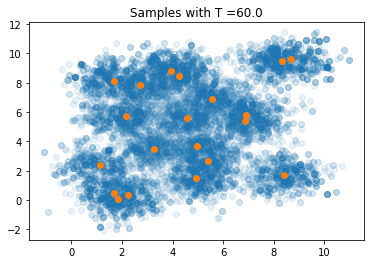

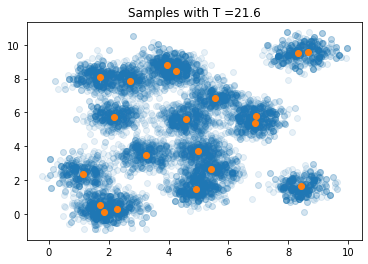

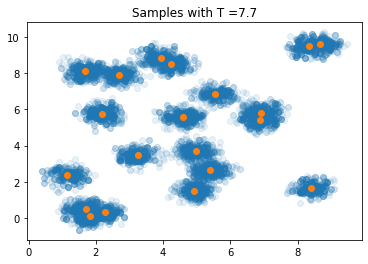

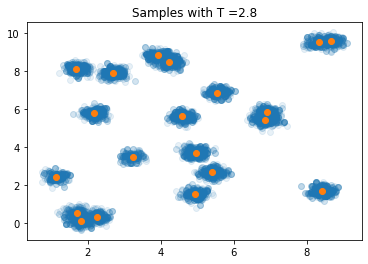

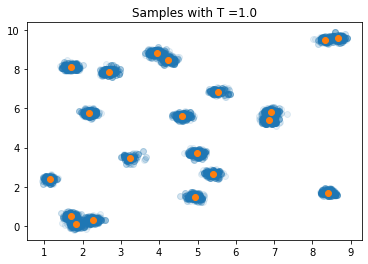

In [603]:
for k in range(T.shape[0]):
    samples_k = samples[:, k,:]
    plt.title("Samples with T =" + str(T[k]))
    plt.scatter(samples_k[:,0], samples_k[:,1], alpha = 0.1)
    plt.scatter(mus[:,0], mus[:,1])
    plt.show()

---
---
---

## Exercise 3: Bayesian analysis of a one-way random effects model


**Question 1.**


We have:

$$\pi_{Y, X, \mu, \sigma^2, \tau^2} \propto \pi_{Y | X, \mu, \sigma^2, \tau^2} \pi_{X | \mu, \sigma^2, \tau^2} \pi_{\mu, \sigma^2, \tau^2}$$


By independance of the $\epsilon$, and independance of the $X_i$, it comes:

$$\pi_{post}(Y, X, \mu, \sigma^2, \tau^2) \propto \frac{1}{\tau^{k}} \prod_i \prod_j exp(\frac{-(X_i- Y_{i,j})^2}{2\tau^2}) \times \frac{1}{\sigma^N}\prod_i  exp(\frac{-(X_i-\mu)^2}{2\sigma^2}) \times \frac{exp(-\beta/\sigma^2)}{\sigma^{2(1 + \alpha)} } \times  \frac{exp(-\beta/\tau^2)}{\tau^{2(1 + \gamma)}}$$



**Question 2.**

The conditional probabilities are given by:

$\bullet$ $$\pi(\sigma^2 |Y, X, \mu, \tau^2) \propto \frac{1}{\sigma^N}\prod_i  exp(\frac{-(X_i-\mu)^2}{2\sigma^2}) \times \frac{exp(-\beta/\sigma^2)}{\sigma^{2(1 + \alpha)} }$$
$$\pi(\sigma^2 |Y, X, \mu, \tau^2) \propto \frac{1}{{\sigma^2}^{1+ (N+ 2\alpha)/2}} exp(\frac{-\sum_i(X_i-\mu)^2}{2\sigma^2} - \beta/\sigma^2)$$


We identify a inverse Gamma law of parameters $(\frac{N+ 2\alpha}{2}, \frac{\sum_i(X_i-\mu)^2}{2} + \beta)$


$\bullet$ Similarly, it comes that $\pi_{\tau^2 |Y, X, \mu, \sigma^2}$ follows an inverse Gamma law of parameters $(\frac{k+ 2\alpha}{2}, \frac{\sum_i \sum_j(X_i- Y_{i,j})^2}{2} + \beta)$


$\bullet$
$$\begin{align*}
 \pi(\mu|Y, X,\sigma^2, \tau^2) 	&\propto  exp(\frac{-\sum_i(X_i-\mu)^2}{2\sigma^2})\\
												&\propto  exp(\frac{-(\sum_i(X_i-\mu)^2}{2\sigma^2})) \propto exp(\frac{-\sum_iX_i^2 - 2 \sum_i X_i \mu +N \mu^2}{2\sigma^2}) \\
												& \propto exp(\frac{- (\frac{\sum_iX_i^2 - 2 \sum_i X_i \mu + N\mu^2}{N})}{ \frac{2\sigma^2}{N}})\\
												& \propto exp(\frac{ -(\mu - \frac{\sum x_i}{N})^2}{ 2 \frac{\sigma^2}{N}})\\
\end{align*}$$

And we ientify here a Normal law of mean  $\frac{\sum x_i}{N}$ and variance $\frac{\sigma^2}{N}$


$\bullet$

$$\begin{align*}
\pi(X |Y, \mu, \sigma^2, \tau^2) 	&\propto \prod_i exp( - \sum_j \frac{(X_i- Y_{i,j})^2}{2\tau^2} +\frac{(X_i-\mu)^2}{2\sigma^2}) \\
									&\propto \prod_i exp( - \frac{X_i^2  + X_i \frac{ \sum_j Y_{ij}/\tau^2 + \mu/\sigma^2 }{k_i/ \tau^2 + 1/ \sigma^2} }{k_i/ \tau^2 + 1/ \sigma^2})\\
									&\propto \prod_i exp( - \frac{X_i^2 + 2 X_i \frac{ \sum_j Y_{ij} \sigma^2+ \mu \tau^2  }{k_i \sigma^2+ \tau^2  } }{2(k_i \sigma^2  + \tau^2) })\\
\end{align*}$$

And, with the same form as the previous one, we can identify a multivariate gaussian of mean of coordinates $$ (\frac{ \sigma^2 \sum_j Y_{ij} + \mu \tau^2  }{k_i \sigma^2+ \tau^2  })_i$$ and covariance matrix  $$diag((k_i \sigma^2  + \tau^2)_i)$$

**Question 2.**

In [168]:
from scipy.stats import invgamma
from IPython.display import clear_output

In [179]:
def gibbs_sampler(y, x_start, mu_start, sigma2_start, tau2_start, alpha, beta, gamma, N_iter):
    """ Gibbs sampler for above distribution """
    
    # Start values
    x = x_start.copy()
    mu, sigma2, tau2 = mu_start, sigma2_start, tau2_start

    # Init variables
    N, ki = y.shape
    k = N*ki
    mus = [mu_start]
    sigma2s = [sigma2_start]
    tau2s = [tau2_start]
    xs = [x]

    for i in range(N_iter):
        # Sample along each dimension
        sigma2 = 1./np.random.gamma(N/2. + alpha, 1./(np.sum((x-mu)**2)/2 + beta))
        tau2 = 1./np.random.gamma(k/2. + gamma, 1./ (np.sum((y - x[:,np.newaxis])**2)/2 + beta))
        mu = np.random.normal(np.mean(x), np.sqrt(sigma2/N))
        x = np.random.multivariate_normal( (sigma2*np.sum(y, axis=1) + mu*tau2)/(ki*sigma2 + tau2), (ki*sigma2 + tau2)*np.eye(N))

        mus.append(mu)
        tau2s.append(tau2)
        sigma2s.append(sigma2)
        xs.append(x)

        # clear_output(wait=True)
        # plt.plot(range(len(mus)), mus)
        # plt.show()
        # plt.plot(range(len(sigma2s)), sigma2s)
        # plt.show()
        # plt.plot(range(len(tau2s)), tau2s)
        # plt.show()



    return(mus, sigma2s, tau2s, xs)


**Question 4**

The block sampler is less computationnaly expensive in it sampling because it only requires to sample fro blocks, assuming that sampling from the "blocked" ditributions is equally computationnaly expensive aas sampling from the individual distribution in Gibbs sampling.

**Question 5.**

In [181]:
alpha = .1
beta = .1
gamma = .1

mu_true = 2.
sigma_true = 1.3
tau_true = .05


N = 1000
k = 10
X = mu_true + sigma_true*np.random.randn(N)
Y = X[:,np.newaxis] + np.random.rand(N,k)*tau_true


In [ ]:
mus, sigma2s, tau2s, xs = gibbs_sampler(Y, 3. +np.random.randn(N), 3., 1.8**2, .1**2, alpha, beta, gamma, 100)


The values sampledfrom my sampler seem to all diverge to infinity, but I could not get the algorithm to evolve in the right way.